In [27]:
# define the paths to data folders
path_to_images = "/home/aditis/decodingEEG/DecodeEEG/data/images/"
path_to_spectrograms = "/home/aditis/decodingEEG/DecodeEEG/data/spectrograms/"

In [ ]:
# define the image to vector class used for extraction

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    def __init__(self, cuda=False, model='resnet-18', layer='default', layer_output_size=512, gpu=0):
            """ Img2Vec
            :param cuda: If set to True, will run forward pass on GPU
            :param model: String name of requested model
            :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
            :param layer_output_size: Int depicting the output size of the requested layer
            """
            self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
            self.layer_output_size = layer_output_size
            self.model_name = model

            self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

            self.model = self.model.to(self.device)

            self.model.eval()

            self.scaler = transforms.Resize((224, 224))
            self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
            self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

        my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        with torch.no_grad():
            h_x = self.model(image)
        h.remove()

        return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(weights=models.ResNet18_Weights.DEFAULT)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer
        else:
            raise KeyError('Model %s was not found' % model_name)

In [22]:
# test the feature vector for a sample image
from PIL import Image
img2vec = Img2Vec()
img = Image.open(path_to_images+"training_images/00001_aardvark/aardvark_10s.jpg").convert('RGB')
vec = img2vec.get_vec(img)

Size of feature vector:  (512,)
Sample image:


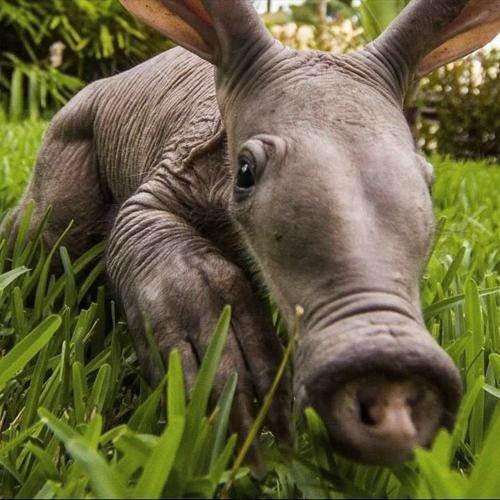

In [26]:
print("Size of feature vector: " ,vec.shape)
print("Sample image:")
img
